In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import cv2
import os
from torchvision import transforms, models
from utils import *
from feature_stabilization import stabilize_video
import matplotlib.pyplot as plt
device = 'cuda'
shape = (H,W,C) = (128,128,3)
from time import time 
start = time()

In [3]:
#set up raft
raft = models.optical_flow.raft_small(weights = 'Raft_Small_Weights.C_T_V2').eval().to(device)
#set up midas
model_type = "MiDaS_small"  # MiDaS v2.1 - Small   (lowest accuracy, highest inference speed)
midas = torch.hub.load("intel-isl/MiDaS", model_type).eval().to(device)
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

Using cache found in C:\Users\VINY/.cache\torch\hub\intel-isl_MiDaS_master
c:\Users\VINY\anaconda3\envs\vision\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading weights:  None


Using cache found in C:\Users\VINY/.cache\torch\hub\rwightman_gen-efficientnet-pytorch_master
Using cache found in C:\Users\VINY/.cache\torch\hub\intel-isl_MiDaS_master


In [9]:
path = 'E:/Datasets/DeepStab_Dataset/unstable/18.avi'
cap = cv2.VideoCapture(path)
Height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
Width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frames = []
while True:
    ret,frame = cap.read()
    if not ret: break
    frames.append(frame)
cap.release()
frames = np.array(frames, np.uint8)
num_frames = frames.shape[0]

In [5]:
from model import MPI_Net
model = MPI_Net(input_channels=40,num_outputs=40, ngf=32).eval().to(device)
ckpt_dir = './ckpts3/'
ckpts = os.listdir(ckpt_dir)
if ckpts:
    ckpts = sorted(ckpts, key = lambda x : int(x.split('.')[0].split('_')[1])) #sort
    latest = ckpts[-1]
    state_dict = torch.load(os.path.join(ckpt_dir,latest))
    model.load_state_dict(state_dict['model'])
    print(f'loaded weights {latest}')


loaded weights mpi_7.pth


In [5]:
frames = stabilize_video(frames, window_size=5)

Estimating trajectory 249/250

Warping frames 249/250

In [6]:
pca_flows, masks = inpaint_flows(frames, raft, midas, midas_transforms)

 idx: 248/250

In [7]:
# Initialize final_flows with the original optical flow fields (shape: [n_frames, h, w, 2])
in_flows = pca_flows.copy() 
warps = np.zeros_like(pca_flows)
n_frames,height,width,_ = warps.shape
window_size = 20
overlap = 2

# Loop through the optical flow fields using a sliding window approach
prev_warp = np.zeros((overlap,height,width,2),dtype=np.float32)
for idx in range(1,n_frames - window_size, window_size- overlap):
    # Extract the current window of optical flow fields
    net_in = in_flows[idx : idx + window_size]
    net_in[:overlap,...] -= prev_warp
    net_in = np.concatenate(net_in, axis=-1)
    net_in = torch.from_numpy(net_in).permute(2, 0, 1).unsqueeze(0).float().cuda()
    with torch.no_grad():
        net_out = model(net_in)
    dx = net_out[:, ::2, :, :]
    dy = net_out[:, 1::2, :, :]
    w = torch.stack([dx, dy], dim=-1).squeeze(0).to('cpu').numpy()
    prev_warp = w[-overlap:,...]
    in_flows[idx + overlap : idx + window_size - overlap] += w[overlap:-overlap,...]
    warps[idx + overlap : idx + window_size - overlap] = w[overlap:-overlap,...]
    flo_rgb = show_flow(w[0,...])
    cv2.imshow('window',flo_rgb)
    if cv2.waitKey(1) & 0xFF == ord(' '):
        break
cv2.destroyAllWindows()

In [10]:
kernel_size = 15 # must be odd
pca_flows_tensor = torch.from_numpy(pca_flows).float().permute(0, 3, 1, 2).float().to(device)
warps_tensor = torch.from_numpy(warps).float().permute(0, 3, 1, 2).float().to(device)
pixel_profiles = torch.cumsum(pca_flows_tensor,dim = 0)
smooth_profiles = pixel_profiles.clone()
for _ in range(20):
    
    profiles_reshaped =smooth_profiles.permute(2,3,1,0).contiguous().view(-1, 2, num_frames)
    smooth_profiles = torch.nn.functional.avg_pool1d(profiles_reshaped,\
                                        kernel_size = kernel_size,\
                                        stride = 1,
                                        padding = kernel_size //2)
    smooth_profiles = smooth_profiles.permute(-1,1,0).view(num_frames,2,H,W)

warps = (smooth_profiles - pixel_profiles).cpu().permute(0,2,3,1).numpy()

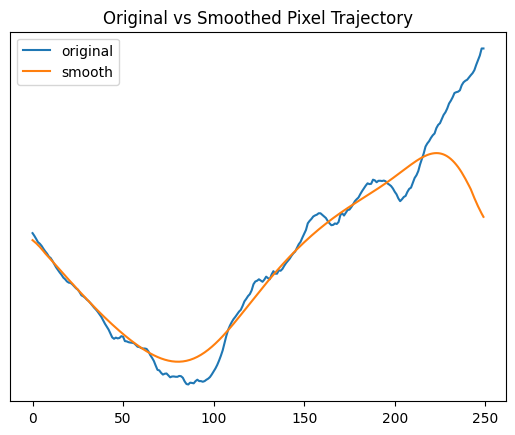

In [11]:
original_trajectory = np.cumsum(pca_flows[:,50,50,0])
smooth_trajectory = original_trajectory + warps[:,50,50,0]
plt.plot(original_trajectory,label='original')
plt.plot(smooth_trajectory,label='smooth')
plt.title('Original vs Smoothed Pixel Trajectory')
plt.yticks([])
plt.legend()

In [10]:
print(time() - start)

57.715492963790894


In [12]:
from time import sleep
#warp and write to file
frame_count, h, w, c = frames.shape
stable_frames = np.zeros((n_frames,h,w,3),dtype=np.uint8)
cv2.namedWindow('window',cv2.WINDOW_NORMAL)
for idx in range(frame_count-1):
    frame = torch.from_numpy(frames[idx,...]/255.0).unsqueeze(0).permute(0,3,1,2).float().cuda()
    flow = torch.from_numpy(warps[idx,...]).unsqueeze(0).permute(0,3,1,2).float().cuda()
    flow = gaussian_blur(flow,kernel_size = 5, sigma = 1, size = (Height,Width))
    warped_image = dense_warp(frame,flow).cpu().squeeze(0).permute(1,2,0).numpy() 
    warped_image = (warped_image * 255).astype(np.uint8)
    stable_frames[idx,...] = warped_image
    cv2.imshow('window',fixBorder(warped_image))
    sleep(1/30)
    if cv2.waitKey(1) & 0xFF == ord(' '):
        break
cv2.destroyAllWindows()

c:\Users\VINY\anaconda3\envs\vision\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
